## Santander Value Prediction Challenge

### Problema de regressão

Nesta competição, o Grupo Santander está pedindo aos Kagglers que os ajudem a identificar o valor das transações para cada cliente em potencial. Este é o primeiro passo que o Santander precisa para personalizar seus serviços em grande escala.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load dos datasets de treino e teste.

In [2]:
train_x = pd.read_csv("data/train.csv")
test_x = pd.read_csv("data/test.csv")

print(train_x.shape)
print(test_x.shape)

(4459, 4993)
(49342, 4992)


Remoção de colunas com valores constantes (std = 0). Para valores iguais na coluna, desvio padrao é 0.

In [3]:
remove = []
#train.drop("ID", axis=1, inplace=True)
#test.drop("ID", axis=1, inplace=True)
for col in train_x.columns:
    if col not in ["ID", "target"]:
        if train_x[col].std() == 0:
            remove.append(col)
#axis: 1 para olhar coluna e 0 para linha
#inplace: faz o replace na propria instancia
train_x.drop(remove, axis=1, inplace=True)
test_x.drop(remove, axis=1, inplace=True)

print(train_x.shape)
print(test_x.shape)

(4459, 4737)
(49342, 4736)


Remoção de colunas duplicadas

In [4]:
remove = []
cols = train_x.columns
for i in range(len(cols)-1):
    v = train_x[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train_x[cols[j]].values):
            remove.append(cols[j])

train_x.drop(remove, axis=1, inplace=True)
test_x.drop(remove, axis=1, inplace=True)

print(train_x.shape)
print(test_x.shape)

(4459, 4732)
(49342, 4731)


Visualização da distribuição do Target através de ScatterPlot

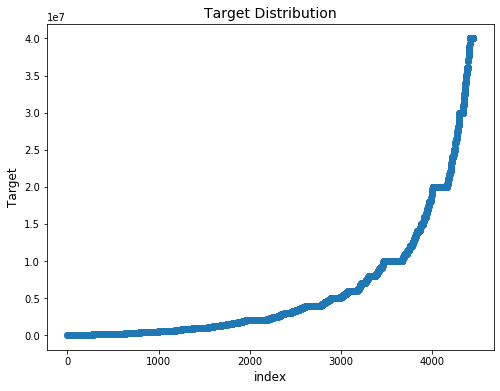

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_x.shape[0]), np.sort(train_x['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

Visualização da distribuição do Target através de Histograma

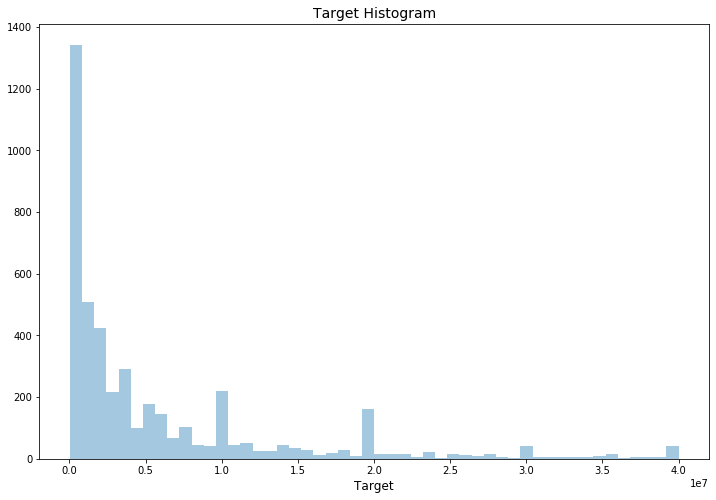

In [6]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.distplot(train_x["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

Visualização da distribuição do Target normalizada pelo log através de Histograma

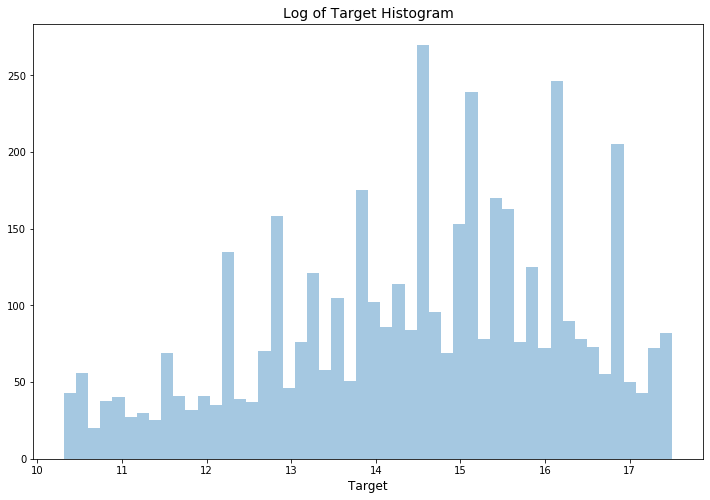

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_x["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

Cópia e remoção dos atributos ID e TARGET

In [5]:
train_y = np.log1p(train_x["target"].values)
test_ids = test_x["ID"].values
train_x.drop(["target", "ID"], axis = 1, inplace = True)
test_x.drop(["ID"],axis=1, inplace = True)
train_x.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


### Redução de dimensionalidade

Duas opções: PCA ou t-SNE

Redução com PCA (Principal component analysis) com 3 componentes

In [19]:
#PCA
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
features = train_x.columns[1:-1]

# Normalize cada caracteristica a norma da unidade (comprimento do vetor)
x_train_normalized = normalize(train_x[features], axis=0)
x_test_normalized = normalize(test_x[features], axis=0)

# Executar PCA
pca = PCA(n_components=3)
x_train_projected = pca.fit_transform(x_train_normalized)
x_test_projected = pca.fit_transform(x_test_normalized)

train_x.insert(1, 'PCAOne', x_train_projected[:, 0])
train_x.insert(1, 'PCATwo', x_train_projected[:, 1])
train_x.insert(1, 'PCAThree', x_train_projected[:, 2])

test_x.insert(1, 'PCAOne', x_test_projected[:, 0])
test_x.insert(1, 'PCATwo', x_test_projected[:, 1])
test_x.insert(1, 'PCAThree', x_test_projected[:, 2])

Redução com PCA com número ótimo de componentes

In [6]:
#Get number of components
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

standardized_train = StandardScaler().fit_transform(train_x.values)
standardized_test = StandardScaler().fit_transform(test_x.values)

def _get_number_components(model, threshold):
    component_variance = model.explained_variance_ratio_
    explained_variance = 0.0
    components = 0

    for var in component_variance:
        explained_variance += var
        components += 1
        if(explained_variance >= threshold):
            break
    return components

### Get the optimal number of components
pca = PCA()
train_pca = pca.fit_transform(standardized_train)
components = _get_number_components(pca, threshold=0.85)
components

994

In [7]:
### Implement PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

standardized_train = StandardScaler().fit_transform(train_x.values)
standardized_test = StandardScaler().fit_transform(test_x.values)

obj_pca = model = PCA(n_components = 20)
x_train_projected = obj_pca.fit_transform(standardized_train)
x_test_projected = obj_pca.fit_transform(standardized_test)

for npca in range(0, 20):
    train_x.insert(1, 'PCA_'+str(npca+1), x_train_projected[:, npca])
    test_x.insert(1, 'PCA_'+str(npca+1), x_test_projected[:, npca])

Redução com t-SNE (t-Distributed Stochastic Neighbor Embedding) com 3 componentes

t-SNE é um algoritmo de aprendizado de máquina para visualização desenvolvido por Laurens van der Maaten e Geoffrey Hinton. É uma técnica de redução de dimensionalidade não linear, adequada para visualizar dados de alta dimensão duas ou três dimensões. Especificamente, ele modela cada objeto de alta dimensão através de um ponto bidimensional ou tridimensional, de modo que objetos semelhantes sejam modelados através de pontos próximos e objetos diferentes sejam modelados através de pontos distantes com alta probabilidade.

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 4459 samples in 0.824s...
[t-SNE] Computed neighbors for 4459 samples in 186.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4459
[t-SNE] Computed conditional probabilities for sample 2000 / 4459
[t-SNE] Computed conditional probabilities for sample 3000 / 4459
[t-SNE] Computed conditional probabilities for sample 4000 / 4459
[t-SNE] Computed conditional probabilities for sample 4459 / 4459
[t-SNE] Mean sigma: 352244.418414
[t-SNE] KL divergence after 250 iterations with early exaggeration: 321.947052
[t-SNE] KL divergence after 1000 iterations: 22.718702


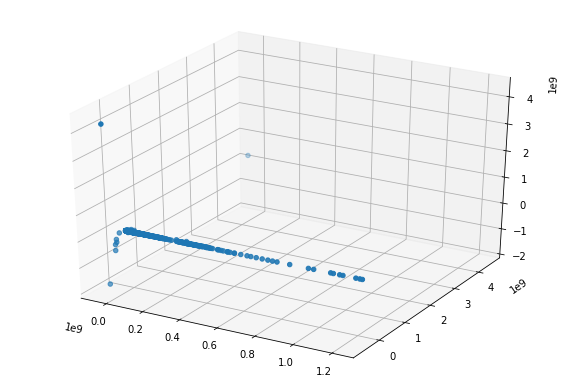

In [7]:
#TSNE
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(data): 
    x, y, z = data.T
    fig = plt.figure(figsize=(10, 5.5/8*10)) 
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)

from sklearn.manifold import TSNE

def run_tsne(x, components, perplexity=15, lr=75.0):
    tsne = TSNE(n_components = components, 
    verbose = 1, 
    perplexity = perplexity, 
    learning_rate = lr,
    init='pca')
    tsne_results = tsne.fit_transform(x)
    return tsne_results

result_train = run_tsne(train_x, 3)
x_train_projected = pd.DataFrame(result_train)

#train_x.insert(1, 'TSNEOne', x_train_projected[:, 0])
#train_x.insert(1, 'TSNETwo', x_train_projected[:, 1])
#train_x.insert(1, 'TSNEThree', x_train_projected[:, 2])

train_x.head()
plot_3d(result_train)

Se você tiver memória suficiente para reduzir o testset, execute a próxima célula, se não, use o PCA.

In [ ]:
result_test = run_tsne(test_x, 3)
x_test_projected = pd.DataFrame(result_test)

test_x.insert(1, 'TSNEOne', x_test_projected[:, 0])
test_x.insert(1, 'TSNETwo', x_test_projected[:, 1])
test_x.insert(1, 'TSNEThree', x_test_projected[:, 2])

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 49342 samples in 21.263s...


Engenharia de feature com Random Forest escolhendo as 1000 features mais relevantes

/home/jessica/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.5409291527243631


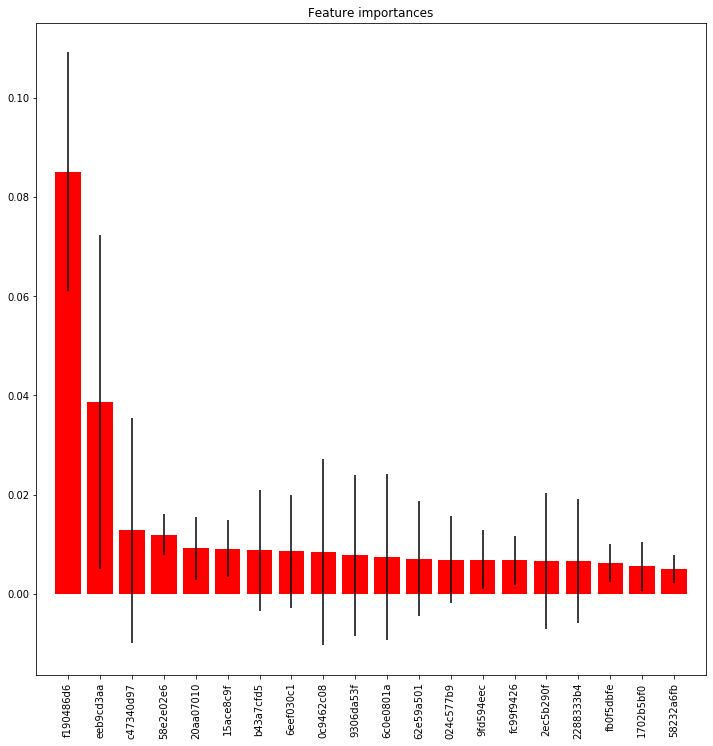

(4459, 1000)

In [10]:
#Feature Engineering
from sklearn import model_selection
from sklearn import ensemble
NUM_OF_FEATURES = 1000
def rmsle(y, pred):
    return np.sqrt(np.mean(np.power(y - pred, 2)))

x1, x2, y1, y2 = model_selection.train_test_split(train_x, train_y, test_size=0.20, random_state=5)
model = ensemble.RandomForestRegressor(n_jobs=-1, random_state=7)
model.fit(x1, y1)
print(rmsle(y2, model.predict(x2)))

## plot the importances ##
feat_names = train_x.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

col = pd.DataFrame({'importance': model.feature_importances_, 'feature': train_x.columns}).sort_values(
    by=['importance'], ascending=[False])[:NUM_OF_FEATURES]['feature'].values
train_x = train_x[col]
test_x = test_x[col]
train_x.shape

Algoritmo LightGBM

LightGBM é um framework de boosting de gradiente que usa algoritmos de aprendizado baseados em árvore. Ele foi projetado para ser distribuído e eficiente com as seguintes vantagens:

-Maior velocidade de treinamento e maior eficiência.

-Menor uso de memória.

-Melhor precisão.

-Suporte ao aprendizado paralelo e GPU.

-Capaz de lidar com dados em larga escala.

In [11]:
import lightgbm as lgb
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

Execução do LightGBM

In [12]:
from sklearn import model_selection
from sklearn import ensemble

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_x):
    dev_X, val_X = train_x.loc[dev_index,:], train_x.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_x)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.4423
[400]	valid_0's rmse: 1.4239
[600]	valid_0's rmse: 1.4229
Early stopping, best iteration is:
[553]	valid_0's rmse: 1.42213
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.44202
[400]	valid_0's rmse: 1.40525
[600]	valid_0's rmse: 1.40101
Early stopping, best iteration is:
[630]	valid_0's rmse: 1.40044
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.44087
[400]	valid_0's rmse: 1.41127
[600]	valid_0's rmse: 1.4077
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.40706
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.48532
[400]	valid_0's rmse: 1.44758
[600]	valid_0's rmse: 1.43986
[800]	valid_0's rmse: 1.43778
[1000]	valid_0's rmse: 1.43838
Did not meet early stopping. Best iteration is:
[933]	valid_0's rmse: 1.43709
Training until validation scores don't improve for 100 rounds


Geração do csv para submissão no Kaggle

In [13]:
sub_df = pd.DataFrame({"ID":test_ids})
sub_df["target"] = pred_test_full
sub_df.to_csv("submission.csv", index=False)